In [1]:
# !pip install librosa

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy import ndimage

import pandas as pd

In [2]:
# Путь к файлу

def open_file(path):
    file_path = path

    # Загружаем звук, приводим к 32kHz
    y, sr = librosa.load(file_path, sr=32000)

    file_name = path.split('/')[-1]
    # Проверим длительность
    # print(f"Имя файла: {file_name}")
    # print(f"Длительность: {len(y) / sr:.2f} сек, Частота: {sr} Гц")
    return y, sr


In [3]:
# Построим мел-спектрограмму
def get_mell(y_denoised, sr):
    S = librosa.feature.melspectrogram(y=y_denoised, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    return S_dB


def draw_mell(S_dB, sr):
    # Отрисовка
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram (denoised)')
    plt.tight_layout()
    plt.show()

In [30]:
import torchaudio.transforms as T
import torch

def get_mell_torch(y_denoised, sr, device='gpu'):
    # Преобразуем NumPy в Tensor
    waveform = torch.tensor(y_denoised).unsqueeze(0).to(device)  # [1, time]
    
    mel_transform = T.MelSpectrogram(
        sample_rate=sr,
        n_fft=1024,
        hop_length=256,
        n_mels=128,
        f_max=8000
    ).to(device)
    
    db_transform = T.AmplitudeToDB(stype="power").to(device)
    
    S = mel_transform(waveform)  # [1, 128, time]
    S_dB = db_transform(S)       # [1, 128, time]
    
    return S_dB.squeeze(0)       # [128, time]


In [4]:
def bandpass_filter(audio, sr, lowcut=400, highcut=2200, order=4):
    """
    Полосовая фильтрация для выделения диапазона частот кода Морзе
    
    Parameters:
        audio: аудио сигнал
        sr: частота дискретизации
        lowcut: нижняя граница частоты (Гц)
        highcut: верхняя граница частоты (Гц)
        order: порядок фильтра
        
    Returns:
        filtered: отфильтрованный сигнал
    """
    nyq = 0.5 * sr
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    filtered = signal.lfilter(b, a, audio)
    return filtered

In [5]:
def adaptive_noise_reduction(audio, sr, frame_len=1024, hop_len=256, beta=0.9):
    """
    Адаптивное подавление шума с использованием спектрального вычитания
    
    Parameters:
        audio: аудио сигнал
        sr: частота дискретизации
        frame_len: длина окна STFT
        hop_len: перекрытие окон STFT
        beta: коэффициент вычитания шума (0-1)
        
    Returns:
        audio_reduced: сигнал с уменьшенным шумом
    """
    # STFT
    stft = librosa.stft(audio, n_fft=frame_len, hop_length=hop_len)
    mag = np.abs(stft)
    phase = np.angle(stft)
    
    # Оценка шума по наименее громким участкам спектрограммы
    # Для этого берем 20% наименее энергичных фреймов
    frame_energies = np.sum(mag, axis=0)
    threshold = np.percentile(frame_energies, 20)
    noise_frames = frame_energies < threshold
    
    # Если не нашли тихих фреймов, используем первые несколько
    if np.sum(noise_frames) < 3:
        noise_frames = np.zeros_like(frame_energies, dtype=bool)
        noise_frames[:5] = True
    
    # Оценка профиля шума
    noise_estimate = np.mean(mag[:, noise_frames], axis=1).reshape(-1, 1)
    
    # Спектральное вычитание
    mag_subtracted = mag - beta * noise_estimate
    mag_subtracted = np.maximum(mag_subtracted, 0.01 * mag)  # Нижний порог шума
    
    # Реконструкция сигнала
    stft_reduced = mag_subtracted * np.exp(1j * phase)
    audio_reduced = librosa.istft(stft_reduced, hop_length=hop_len, length=len(audio))
    
    return audio_reduced

In [6]:
def envelope_detection(audio, sr, lowpass_freq=30):
    """
    Извлечение огибающей сигнала для обнаружения точек и тире
    
    Parameters:
        audio: аудио сигнал
        sr: частота дискретизации
        lowpass_freq: частота среза низкочастотного фильтра (Гц)
        
    Returns:
        envelope: огибающая сигнала
    """
    # Выпрямление сигнала (получение модуля)
    rectified = np.abs(audio)
    
    # Низкочастотная фильтрация для получения огибающей
    nyq = 0.5 * sr
    cutoff = lowpass_freq / nyq
    b, a = signal.butter(3, cutoff, btype='low')
    envelope = signal.filtfilt(b, a, rectified)
    
    return envelope

In [7]:
def adaptive_thresholding(envelope, window_size=4000, c=0.6):
    """
    Адаптивное пороговое значение для определения сигнал/не сигнал
    
    Parameters:
        envelope: огибающая сигнала
        window_size: размер окна для вычисления локального среднего
        c: коэффициент порога (0-1)
        
    Returns:
        binary_signal: бинаризованный сигнал (1 - есть сигнал, 0 - нет)
        threshold: порог бинаризации
    """
    # Создаем скользящее среднее для вычисления адаптивного порога
    window = np.ones(window_size) / window_size
    # Сглаженная огибающая для вычисления порога
    smoothed = np.convolve(envelope, window, mode='same')
    
    # Адаптивный порог
    threshold = c * smoothed
    
    # Бинаризация с адаптивным порогом
    binary_signal = (envelope > threshold).astype(float)
    
    return binary_signal, threshold

In [8]:
def morphological_filtering(binary_signal, min_duration=8, max_gap=10):
    """
    Морфологическая фильтрация для удаления коротких выбросов и заполнения промежутков
    
    Parameters:
        binary_signal: бинаризованный сигнал
        min_duration: минимальная продолжительность сигнала (отсчеты)
        max_gap: максимальный промежуток для заполнения (отсчеты)
        
    Returns:
        filtered_binary: отфильтрованный бинарный сигнал
    """
    # Удаление коротких выбросов (операция открытия)
    opened = ndimage.binary_opening(binary_signal, structure=np.ones(min_duration))
    
    # Заполнение коротких промежутков (операция закрытия)
    filtered_binary = ndimage.binary_closing(opened, structure=np.ones(max_gap))
    
    return filtered_binary

In [9]:
def dynamic_range_compression(audio, threshold_db=-30, ratio=4):
    """
    Применение компрессии к аудиосигналу
    Parameters:
        threshold_db: уровень, ниже которого сигнал усиливается
        ratio: коэффициент компрессии
    Returns:
        compressed: компрессированный сигнал
    """
    # Переводим в dB
    eps = 1e-6
    audio_db = 20 * np.log10(np.abs(audio) + eps)
    
    # Применяем компрессию
    gain_db = np.where(audio_db < threshold_db,
                       (threshold_db - audio_db) * (1 - 1/ratio),
                       0)
    gain = 10 ** (gain_db / 20)
    
    return audio * gain


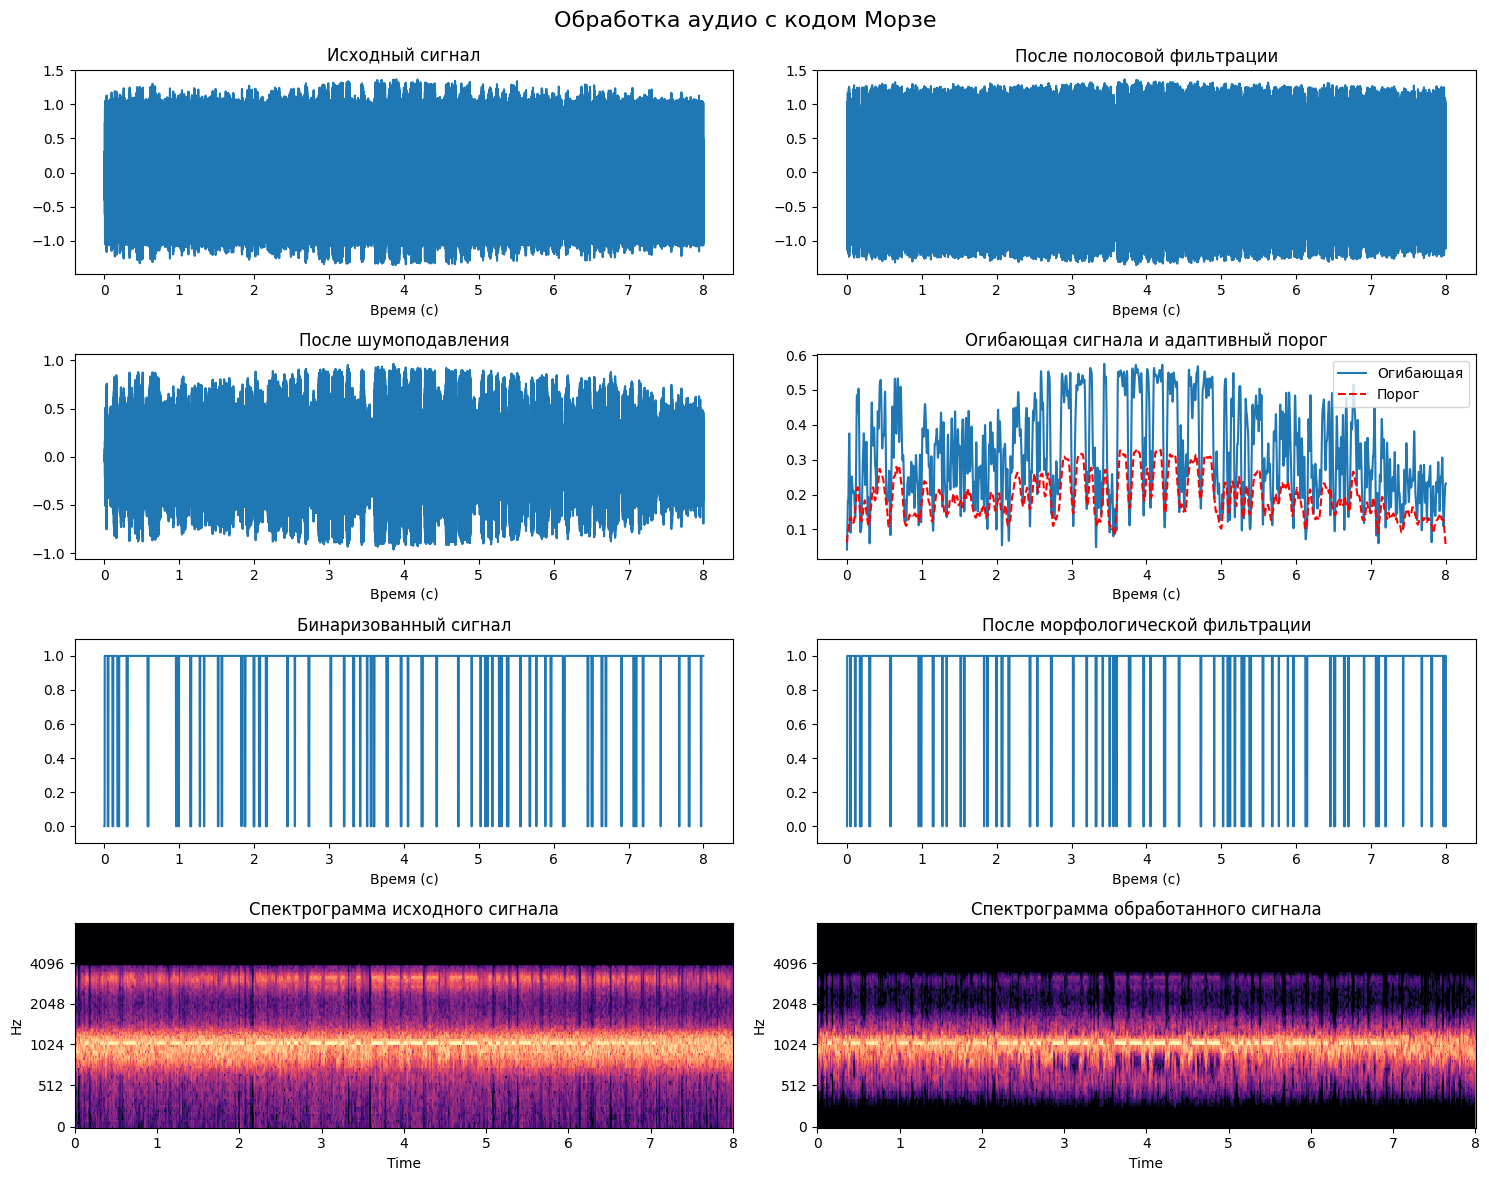

In [93]:
import noisereduce as nr

def process_morse_audio(audio_path, visualize=True): 
    """
    Полный пайплайн обработки аудио с кодом Морзе
    
    Parameters:
        audio_path: путь к аудиофайлу
        visualize: отображать ли графики обработки
        
    Returns:
        results: словарь с результатами обработки
    """
    # Загрузка аудио
    audio, sr = open_file(audio_path)
    
    # Шаг 1: Полосовая фильтрация
    filtered = bandpass_filter(audio, sr, lowcut=500, highcut=1600)
    # filtered = audio
    
    # Шаг 2: Адаптивное подавление шума
    denoised = adaptive_noise_reduction(filtered, sr, frame_len=1024, hop_len=256, beta=0.9)
    
    # Шаг 3: Компрессия динамического диапазона
    # compressed = dynamic_range_compression(denoised, threshold_db=-50, ratio=4)
    compressed = denoised # пропущу компрессию так-как толку от нее визуально нет никакого
    
    # Шаг 4: Извлечение огибающей
    envelope = envelope_detection(compressed, sr, lowpass_freq=40)
    
    # Шаг 5: Адаптивное пороговое значение
    binary_signal, threshold = adaptive_thresholding(envelope)
    
    # Шаг 6: Морфологическая фильтрация
    filtered_binary = morphological_filtering(binary_signal)
    
    # Шаг 7: Создание мел-спектрограммы для обработанного сигнала
    S_dB = get_mell(compressed, sr)
    
    results = {
        'original': audio,
        'filtered': filtered,
        'denoised': denoised,
        'compressed': compressed,
        'envelope': envelope,
        'threshold': threshold,
        'binary': binary_signal,
        'filtered_binary': filtered_binary,
        'spectrogram': S_dB,
        'sr': sr
    }
    
    # Визуализация результатов
    if visualize:
        visualize_processing_steps(results)
    
    return results


# Функция визуализации результатов обработки
def visualize_processing_steps(results):
    """
    Визуализация всех этапов обработки
    
    Parameters:
        results: словарь с результатами обработки
    """
    sr = results['sr']
    
    # Создаем сетку графиков
    fig, axes = plt.subplots(4, 2, figsize=(15, 12))
    fig.suptitle('Обработка аудио с кодом Морзе', fontsize=16)
    
    # Время для оси X
    time = np.arange(len(results['original'])) / sr
    
    # 1. Исходный сигнал
    axes[0, 0].plot(time, results['original'])
    axes[0, 0].set_title('Исходный сигнал')
    axes[0, 0].set_xlabel('Время (с)')
    
    # 2. После полосовой фильтрации
    axes[0, 1].plot(time, results['filtered'])
    axes[0, 1].set_title('После полосовой фильтрации')
    axes[0, 1].set_xlabel('Время (с)')
    
    # 3. После шумоподавления
    axes[1, 0].plot(time, results['denoised'])
    axes[1, 0].set_title('После шумоподавления')
    axes[1, 0].set_xlabel('Время (с)')
    
    # 4. Огибающая и порог
    axes[1, 1].plot(time, results['envelope'], label='Огибающая')
    axes[1, 1].plot(time, results['threshold'], 'r--', label='Порог')
    axes[1, 1].set_title('Огибающая сигнала и адаптивный порог')
    axes[1, 1].set_xlabel('Время (с)')
    axes[1, 1].legend()
    
    # 5. Бинаризованный сигнал
    axes[2, 0].plot(time, results['binary'])
    axes[2, 0].set_title('Бинаризованный сигнал')
    axes[2, 0].set_xlabel('Время (с)')
    axes[2, 0].set_ylim(-0.1, 1.1)
    
    # 6. Отфильтрованный бинарный сигнал
    axes[2, 1].plot(time, results['filtered_binary'])
    axes[2, 1].set_title('После морфологической фильтрации')
    axes[2, 1].set_xlabel('Время (с)')
    axes[2, 1].set_ylim(-0.1, 1.1)
    
    # 7. Исходная спектрограмма
    S_original = get_mell(results['original'], sr)
    librosa.display.specshow(S_original, 
                           sr=sr, 
                           x_axis='time', 
                           y_axis='mel', 
                           fmax=8000, 
                           ax=axes[3, 0])
    axes[3, 0].set_title('Спектрограмма исходного сигнала')
    
    # 8. Спектрограмма обработанного сигнала
    librosa.display.specshow(results['spectrogram'], 
                           sr=sr, 
                           x_axis='time', 
                           y_axis='mel', 
                           fmax=8000, 
                           ax=axes[3, 1])
    axes[3, 1].set_title('Спектрограмма обработанного сигнала')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

# Пример использования
if __name__ == "__main__":
    # Укажите путь к вашему аудиофайлу
    audio_path = "data/morse_dataset/morse_dataset/31.opus"
    
    # Запустите полный пайплайн обработки
    results = process_morse_audio(audio_path)
    
    # Если нужно получить только обработанный сигнал без визуализации
    # results = process_morse_audio(audio_path, visualize=False)
    
    # Доступ к спектрограмме для дальнейшего использования в модели
    spectrogram = results['spectrogram']

In [4]:
def path_to_files_from_n_to_m(n, m):
    base_path="data/morse_dataset/morse_dataset/"
    paths = list()
    for i in range(n, m):
        paths.append(base_path + str(i) + ".opus")
    return paths

data/morse_dataset/morse_dataset/1.opus


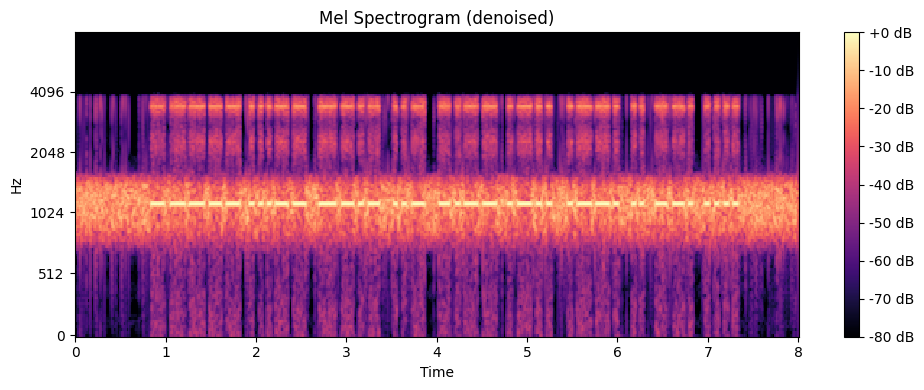

data/morse_dataset/morse_dataset/2.opus


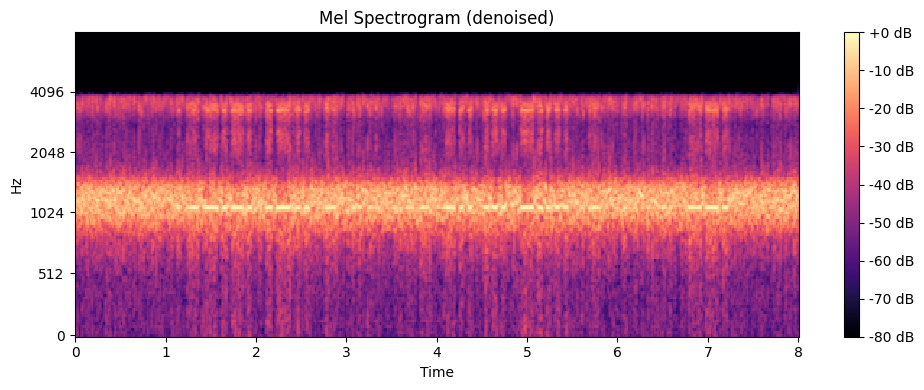

data/morse_dataset/morse_dataset/3.opus


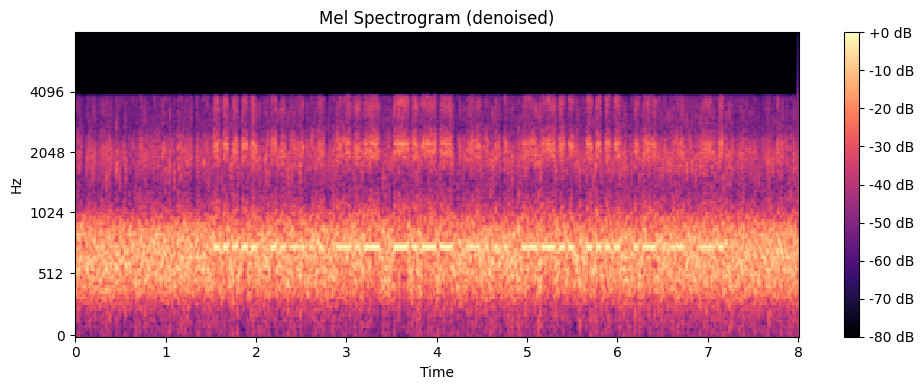

data/morse_dataset/morse_dataset/4.opus


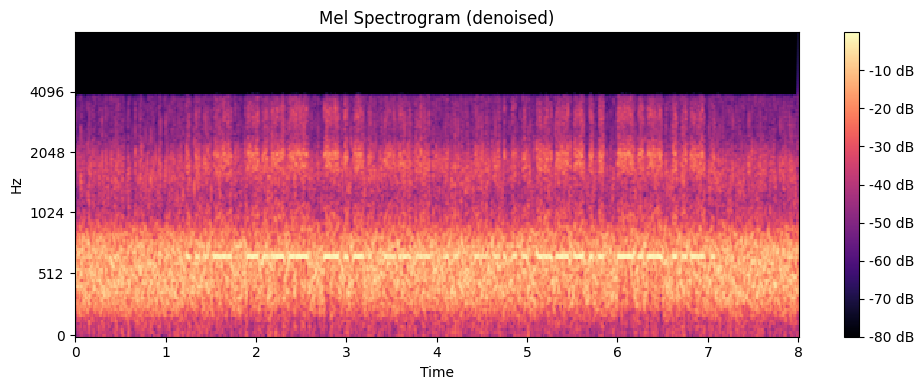

In [5]:
for i in path_to_files_from_n_to_m(1, 5):
    print(i)
    y, sr = open_file(i)
    S_db = get_mell(y, sr)
    
    # r = process_morse_audio(i, visualize=False)
    # S_db = r['spectrogram']
    # sr = r['sr']
    draw_mell(S_db, sr)

In [12]:
train_df = pd.read_csv('data/train.csv')
train_df.head(5)
train_df.loc[5:9]

,id,message
5,6.opus,7У98ШБ2
6,7.opus,УЗОЗ#Г8
7,8.opus,Ц Ж4 РЯХТЛ ВЕ
8,9.opus,ХЮЦ4ЙК5ГЦЯ С
9,10.opus,ЯЗЛ ЮОШЪЕ


Сопоставив несколько файлов руками, понял что код морзе никак не перемешан и не изобретён заново. Используется реальный морзе алфавит

In [13]:
MORSE_DICT = {
    "А": ".-",     "Б": "-...",   "В": ".--",    "Г": "--.",    "Д": "-..",
    "Е": ".",      "Ж": "...-",   "З": "--..",   "И": "..",     "Й": ".---",
    "К": "-.-",    "Л": ".-..",   "М": "--",     "Н": "-.",     "О": "---",
    "П": ".--.",   "Р": ".-.",    "С": "...",    "Т": "-",      "У": "..-",
    "Ф": "..-.",   "Х": "....",   "Ц": "-.-.",   "Ч": "---.",   "Ш": "----",
    "Щ": "--.-",   "Ъ": "--.--",  "Ы": "-.--",   "Ь": "-..-",   "Э": "..-..",
    "Ю": "..--",   "Я": ".-.-",   "1": ".----",  "2": "..---",  "3": "...--",
    "4": "....-",  "5": ".....",  "6": "-....",  "7": "--...",  "8": "---..",
    "9": "----.",  "0": "-----",  "#": "--.--",  " ": " " # решетка получена при ручном анализе файлов
}


def to_morse(msg):
    return ' '.join(MORSE_DICT.get(char.upper(), '') for char in msg)

In [9]:
train_df["morse"] = train_df["message"].apply(to_morse)
train_df.head()

,id,message,morse
0,1.opus,03ЩУЫЛПИГХ,----- ...-- --.- ..- -.-- .-.. .--. .. --. ....
1,2.opus,ЪЛТ0ДС6А3Г,--.-- .-.. - ----- -.. ... -.... .- ...-- --.
2,3.opus,5ЭКЫБЗХЯН,..... ..-.. -.- -.-- -... --.. .... .-.- -.
3,4.opus,ЖЫЦОИ68КФ,...- -.-- -.-. --- .. -.... ---.. -.- ..-.
4,5.opus,32Ю7МЫ ЗЛ,...-- ..--- ..-- --... -- -.-- --.. .-..


In [5]:
# Все буквы русского алфавита + цифры + спецсимволы, которые встречаются
RUSSIAN_CHARS = list("АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ")  # 33
DIGITS = list("0123456789")  # 10
EXTRA = [' ', '#']  # пробел и что ещё нужно
ALL_CHARS = RUSSIAN_CHARS + DIGITS + EXTRA

CHAR_TO_INDEX = {c: i + 1 for i, c in enumerate(ALL_CHARS)}
CHAR_TO_INDEX['<blank>'] = 0
INDEX_TO_CHAR = {i: c for c, i in CHAR_TO_INDEX.items()}
print(CHAR_TO_INDEX['<blank>'])
print(INDEX_TO_CHAR[0])

0
<blank>


In [7]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

class MorseAudioPreprocessor:
    def __init__(self, sample_rate=64000):
        self.sample_rate = sample_rate
        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=2048,
            hop_length=512,
            n_mels=64,
            f_min=600,
            f_max=1000,
            window_fn=torch.hamming_window,
            power=2.0
        )
    
    def preprocess(self, waveform):
        # 1. Нормализация амплитуды
        waveform = waveform / (torch.max(torch.abs(waveform)) + 1e-9)
        
        # 2. Полосовая фильтрация
        waveform = F.bandpass_biquad(waveform, self.sample_rate, 800, 5)
        
        # 3. Спектральное вычитание
        waveform = self._spectral_subtraction(waveform)
        
        # 4. Преобразование в мел-спектрограмму
        mel_spec = self.mel_transform(waveform)
        
        # 5. Логарифмирование (улучшает контраст)
        log_mel_spec = torch.log(mel_spec + 1e-9)
        
        # 6. Адаптивная пороговая обработка для улучшения видимости точек и тире
        enhanced_spec = self._enhance_morse_features(log_mel_spec)
        
        return enhanced_spec
    
    def _spectral_subtraction(self, waveform, n_fft=2048, hop_length=512):
        # Упрощенное спектральное вычитание
        spec = torch.stft(
            waveform, 
            n_fft=n_fft, 
            hop_length=hop_length, 
            window=torch.hann_window(n_fft).to(waveform.device),
            return_complex=True
        )
        
        # Используем первые 10% фреймов для оценки шума
        noise_frames = max(1, int(spec.shape[2] * 0.1))
        noise_estimate = torch.mean(torch.abs(spec[:, :, :noise_frames]), dim=2, keepdim=True)
        
        # Вычитаем шум
        denoised_mag = torch.abs(spec) - 2.0 * noise_estimate
        denoised_mag = torch.clamp(denoised_mag, min=0.0)
        
        # Восстанавливаем с исходной фазой
        denoised_spec = denoised_mag * torch.exp(1j * torch.angle(spec))
        
        # Обратное преобразование
        denoised_wave = torch.istft(
            denoised_spec, 
            n_fft=n_fft, 
            hop_length=hop_length,
            window=torch.hann_window(n_fft).to(waveform.device),
            length=waveform.shape[1]
        )
        
        return denoised_wave
    
    def _enhance_morse_features(self, log_mel_spec):
        # Нормализация
        mean = torch.mean(log_mel_spec)
        std = torch.std(log_mel_spec)
        norm_spec = (log_mel_spec - mean) / (std + 1e-9)
        
        # Нелинейное усиление контраста
        enhanced = torch.tanh(norm_spec * 2)
        
        return enhanced

In [6]:
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset
import torch
import pandas as pd

class MorseDataset(Dataset):
    def __init__(self, df: pd.DataFrame, audio_dir: str):
        self.df = df
        self.audio_dir = audio_dir

        # Параметры спектрограммы torch, но мне больше нравится из librosa
        # self.sample_rate = 32000
        # self.mel_transform = T.MelSpectrogram(
        #     sample_rate=self.sample_rate,
        #     n_fft=2048,       # Увеличено для лучшего частотного разрешения
        #     hop_length=512,   # Оптимизировано для кода Морзе
        #     n_mels=128,        
        #     f_min=512,        # Добавлен нижний порог для фокуса на типичной частоте морзе
        #     f_max=2248,       # Сужен верхний диапазон для концентрации на частотах морзе
        #     window_fn=torch.hamming_window,  
        #     power=2.0         # Квадрат амплитуды для лучшего выделения сигнала
        # )
        # self.db_transform = T.AmplitudeToDB(stype='power')

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = f"{self.audio_dir}/{row['id']}"

        # # === Вариант с torchaudio ===
        # waveform, sr = torchaudio.load(file_path)  # [1, time]
        # if sr != self.sample_rate:
        #     resampler = T.Resample(sr, self.sample_rate)
        #     waveform = resampler(waveform)

        # S = self.mel_transform(waveform)  # [1, n_mels, time]
        # S_dB = self.db_transform(S).squeeze(0)  # [n_mels, time]

        # # Нормализация
        # S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
        # spectrogram = S_dB.unsqueeze(0)  # [1, n_mels, time]

        # === вариант без torchaudio ===
        y, sr = open_file(file_path)
        S_dB = torch.from_numpy(get_mell(y, sr))  # (n_mels, time)
        S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
        spectrogram = S_dB.unsqueeze(0)  # (1, n_mels, time)

        # === С обработкой ===
        # r = process_morse_audio(file_path, visualize=False)
        # S_dB = torch.from_numpy(r['spectrogram']).float()
        # S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
        # spectrogram = S_dB.unsqueeze(0)  # (1, n_mels, time)

        # Текст в индекс
        message = row['message'].strip().upper()
        label = [CHAR_TO_INDEX[c] for c in message if c in CHAR_TO_INDEX]

        return spectrogram, torch.tensor(label, dtype=torch.long)


In [7]:
def collate_fn(batch):
    spectrograms = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Вычисляем длины исходных спектрограмм
    input_lengths = torch.tensor([spec.shape[2] for spec in spectrograms], dtype=torch.long)
    
    # Паддинг спектрограмм
    spectrograms = torch.nn.utils.rnn.pad_sequence(
        spectrograms,
        batch_first=True,
        padding_value=0
    )
    
    # Паддинг меток
    label_lengths = torch.tensor([len(label) for label in labels], dtype=torch.long)
    labels = torch.nn.utils.rnn.pad_sequence(
        labels,
        batch_first=True,
        padding_value=-1
    )
    
    return spectrograms, labels, input_lengths, label_lengths

Ген спектрограмма: torch.Size([1, 128, 501])
Спектрограмма: torch.Size([1, 128, 501])
Метка (индексы): tensor([34, 37, 27, 21, 29, 13, 17, 10,  4, 23])
Метка (символы): 03ЩУЫЛПИГХ


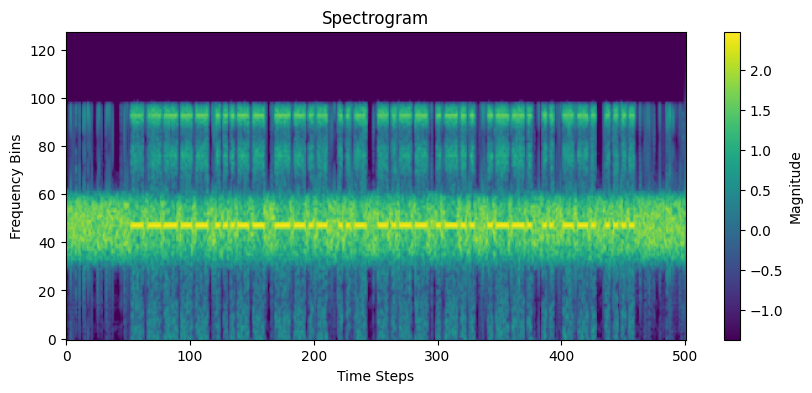

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset

df = pd.read_csv('data/train.csv')
dataset = MorseDataset(df, 'data/morse_dataset/morse_dataset')

df_generated = pd.read_csv('data_generated/morse_data/metadata.csv')
dataset_genearated = MorseDataset(df_generated, 'data_generated/morse_data/audio')

df_augmented = pd.read_csv('data_augmented/morse_data/metadata.csv')
dataset_augmented = MorseDataset(df_augmented, 'data_augmented/morse_data/audio')

combined_dataset = ConcatDataset([dataset, dataset_augmented, dataset_genearated])
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


spectrogram, label = dataset[0]

spectrogram_gen, label_gen = dataset_genearated[30]

print('Ген спектрограмма:', spectrogram_gen.shape)
print("Спектрограмма:", spectrogram.shape)
print("Метка (индексы):", label)
print("Метка (символы):", ''.join([INDEX_TO_CHAR[i.item()] for i in label]))

# Рисуем спектрограмму
spectrogram = spectrogram.squeeze(0) 
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis')

# Добавляем подписи к осям
plt.title('Spectrogram')
plt.xlabel('Time Steps')
plt.ylabel('Frequency Bins')

# Добавляем цветовую шкалу
plt.colorbar(label='Magnitude')

# Показываем график
plt.show()


In [ ]:
# import pandas as pd

# # Основной и сгенерированный датасеты
# df = pd.read_csv('data/train.csv')
# df_generated = pd.read_csv('data_generated/morse_data/metadata.csv')
# df_augmented = pd.read_csv('data_augmented/morse_data/metadata.csv')

# from torch.utils.data import ConcatDataset, Subset
# from sklearn.model_selection import train_test_split
# import numpy as np

# # Объединяем df и df_generated (без аугментаций)
# df_combined = pd.concat([df, df_generated], ignore_index=True)

# # Разбиваем только df_combined
# train_df, val_df = train_test_split(df_combined, test_size=0.2, random_state=42, shuffle=True)

# # Получаем список ID из валидации
# val_ids = set(val_df['id'].values)

# # Фильтруем аугментированные, чтобы удалить утечку
# df_augmented_filtered = df_augmented[~df_augmented['id'].isin(val_ids)]

# dataset_train = MorseDataset(train_df, 'data/morse_dataset/morse_dataset')
# dataset_val = MorseDataset(val_df, 'data/morse_dataset/morse_dataset')

# dataset_augmented_filtered = MorseDataset(df_augmented_filtered, 'data_augmented/morse_data/audio')

# # Финальный тренировочный датасет (оригинал + сгенерированные + безопасные аугментированные)
# from torch.utils.data import ConcatDataset
# final_train_dataset = ConcatDataset([dataset_train, dataset_augmented_filtered])



In [13]:
# Также важное наблюдение, хоть все входные данные и имеют одинаковый размер 8сек -> тензор Спектрограмма: torch.Size([1, 128, 501])
# Метки могут быть разной длины. По крайней мере бывают длиной от 6 до 14 символов

Расчёт размерностей
Для входа [1, 128, 501]:

После CNN:

Conv1 + MaxPool(2,2) → [32, 64, 250]

Conv2 + MaxPool(2,2) → [64, 32, 125]

Conv3 + MaxPool(2,1) → [128, 16, 125] (сохраняем временную длину)

Перед RNN:

reshape → [batch, 125, 128*16] = [batch, 125, 2048]

После BiLSTM:

[batch, 125, 512] (при hidden_size=256)

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MorseCRNN(nn.Module):
    def __init__(self, num_classes, hidden_size=256, cnn_out_channels=128, dropout_cnn=0.2, dropout_rnn=0.3, dropout_fc=0.35):
        super().__init__()
        
        # CNN часть (оптимизирована для вашей спектрограммы)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_cnn),
            nn.MaxPool2d(2, 2),  # [32, 64, 250]
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_cnn),
            nn.MaxPool2d(2, 2),  # [64, 32, 125]
            
            nn.Conv2d(64, cnn_out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(cnn_out_channels),
            nn.ReLU(),
            nn.Dropout2d(dropout_cnn),
            nn.MaxPool2d((2, 1), stride=(2, 1))  # [128, 16, 125] (сохраняем временную длину)
        )
        
        # RNN часть (BiLSTM)
        self.rnn = nn.LSTM(
            input_size=cnn_out_channels * 16,  # После CNN height=16
            hidden_size=hidden_size,
            num_layers=2,
            bidirectional=True,
            batch_first=True,
            dropout=dropout_rnn 
        )
        
        self.dropout_fc = nn.Dropout(dropout_fc)
        # Классификатор
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 для bidirectional

    def forward(self, x):
        # x: [batch, 1, 128, 501]
        x = self.cnn(x)  # [batch, 128, 16, 125]
        
        # Подготовка для RNN
        batch, channels, height, time = x.size()
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, height]
        x = x.reshape(batch, time, channels * height)  # [batch, time, features]
        
        # RNN
        x, _ = self.rnn(x)  # [batch, time, hidden_size*2]
        
        
        # Дополнительный Dropout перед классификацией
        x = self.dropout_fc(x)
        
        # Классификация
        x = self.fc(x)  # [batch, time, num_classes]
        return F.log_softmax(x, dim=2)
    
    def cnn_output_length(self, input_length):
        """Вычисляет длину временной оси после всех CNN слоев"""
        length = input_length
        for layer in self.cnn:
            if isinstance(layer, nn.Conv2d):
                # Для Conv2d с padding=1 и stride=1 длина не меняется
                pass
            elif isinstance(layer, nn.MaxPool2d):
                # Для MaxPool2d применяем целочисленное деление
                kernel_size = layer.kernel_size
                stride = layer.stride
                if isinstance(kernel_size, int):
                    kernel_size = (kernel_size, kernel_size)
                if isinstance(stride, int):
                    stride = (stride, stride)
                length = length // stride[1]  # Делим по временной оси
        return length

In [12]:
import os
import torch
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch.nn as nn

def train(model, dataset, device, epochs=10, batch_size=32, final_fit=False,
          early_stopping_patience=5, model_path="best_model_3.pt"):
    
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    criterion = nn.CTCLoss(blank=0)

    # Разделение train/val, если не финальное обучение
    if not final_fit:
        val_size = int(0.2 * len(dataset))
        train_size = len(dataset) - val_size
        train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
        
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    else:
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = None

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)

        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 30)

        progress_bar = tqdm(enumerate(train_loader), total=total_batches, desc=f"Train {epoch+1}")
        for batch_idx, (spectrograms, labels, input_lengths, label_lengths) in progress_bar:
            spectrograms = spectrograms.to(device)
            labels = labels.to(device)

            outputs = model(spectrograms)
            outputs = outputs.permute(1, 0, 2)

            cnn_time = model.cnn_output_length(input_lengths)
            loss = criterion(outputs, labels, cnn_time, label_lengths)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)

            progress_bar.set_postfix({
                "Train Loss": f"{avg_loss:.4f}",
                "LR": f"{optimizer.param_groups[0]['lr']:.2e}"
            })

        print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for spectrograms, labels, input_lengths, label_lengths in val_loader:
                    spectrograms = spectrograms.to(device)
                    labels = labels.to(device)

                    outputs = model(spectrograms)
                    outputs = outputs.permute(1, 0, 2)

                    cnn_time = model.cnn_output_length(input_lengths)
                    loss = criterion(outputs, labels, cnn_time, label_lengths)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f}")

            # Early Stopping Check
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                torch.save(model.state_dict(), model_path)
                print(f"New best model saved with val loss: {best_val_loss:.4f}")
            else:
                patience_counter += 1
                print(f"No improvement ({patience_counter}/{early_stopping_patience})")

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break

    print("\nTraining completed!")
    if os.path.exists(model_path):
        print(f"Best model saved at: {model_path}")


In [13]:
model = MorseCRNN(num_classes=len(CHAR_TO_INDEX))
print(f"Параметров: {sum(p.numel() for p in model.parameters()):,}")  

Параметров: 6,416,366


In [ ]:
# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train(model, dataset, device, epochs=10, final_fit=True)

Using device: cuda

Epoch 1/10
------------------------------


Epoch 1: 100%|██████████| 938/938 [12:31<00:00,  1.25it/s, Loss=3.9791, LR=3.00e-04]



Epoch 1 summary:
Average Loss: 3.9791
Learning Rate: 3.00e-04

Epoch 2/10
------------------------------


Epoch 2: 100%|██████████| 938/938 [11:40<00:00,  1.34it/s, Loss=3.9448, LR=3.00e-04]



Epoch 2 summary:
Average Loss: 3.9448
Learning Rate: 3.00e-04

Epoch 3/10
------------------------------


Epoch 3: 100%|██████████| 938/938 [11:34<00:00,  1.35it/s, Loss=2.6613, LR=3.00e-04]



Epoch 3 summary:
Average Loss: 2.6613
Learning Rate: 3.00e-04

Epoch 4/10
------------------------------


Epoch 4: 100%|██████████| 938/938 [12:13<00:00,  1.28it/s, Loss=0.5199, LR=3.00e-04]



Epoch 4 summary:
Average Loss: 0.5199
Learning Rate: 3.00e-04

Epoch 5/10
------------------------------


Epoch 5: 100%|██████████| 938/938 [11:46<00:00,  1.33it/s, Loss=0.3304, LR=3.00e-04]



Epoch 5 summary:
Average Loss: 0.3304
Learning Rate: 3.00e-04

Epoch 6/10
------------------------------


Epoch 6: 100%|██████████| 938/938 [11:52<00:00,  1.32it/s, Loss=0.2623, LR=3.00e-04]



Epoch 6 summary:
Average Loss: 0.2623
Learning Rate: 3.00e-04

Epoch 7/10
------------------------------


Epoch 7: 100%|██████████| 938/938 [11:43<00:00,  1.33it/s, Loss=0.2206, LR=3.00e-04]



Epoch 7 summary:
Average Loss: 0.2206
Learning Rate: 3.00e-04

Epoch 8/10
------------------------------


Epoch 8: 100%|██████████| 938/938 [11:25<00:00,  1.37it/s, Loss=0.1913, LR=3.00e-04]



Epoch 8 summary:
Average Loss: 0.1913
Learning Rate: 3.00e-04

Epoch 9/10
------------------------------


Epoch 9: 100%|██████████| 938/938 [11:54<00:00,  1.31it/s, Loss=0.1677, LR=3.00e-04]



Epoch 9 summary:
Average Loss: 0.1677
Learning Rate: 3.00e-04

Epoch 10/10
------------------------------


Epoch 10: 100%|██████████| 938/938 [11:59<00:00,  1.30it/s, Loss=0.1508, LR=3.00e-04]


Epoch 10 summary:
Average Loss: 0.1508
Learning Rate: 3.00e-04

Training completed!


In [ ]:
# # Сохраняем модель (после завершения обучения)
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'char_to_index': CHAR_TO_INDEX,  # Сохраняем словарь для декодирования
#     'index_to_char': INDEX_TO_CHAR
# }, 'morse_model_complete.pth')

# print("Модель сохранена в morse_model_complete.pth")

Модель сохранена в morse_model_complete.pth


In [14]:
def predict(model, file_path, device):
    model.eval()
    model.to(device)
    
    # Шаг 1: Загрузить аудио и получить спектрограмму
    y, sr = open_file(file_path)
    S_dB = torch.from_numpy(get_mell(y, sr))  # (n_mels, time)
    S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
    spectrogram = S_dB.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, n_mels, time]
    
    # Шаг 2: Прогнать через модель
    with torch.no_grad():
        output = model(spectrogram)  # [1, time, num_classes]
        output = output.permute(1, 0, 2)  # [time, 1, num_classes]
    
    # Шаг 3: Greedy decoding (CTC)
    predicted_indices = torch.argmax(output, dim=2).squeeze(1)  # [time]
    
    # Удаляем повторяющиеся символы и blank'и (0)
    prev = -1
    decoded = []
    for idx in predicted_indices:
        idx = idx.item()
        if idx != prev and idx != 0:  # 0 — это blank
            decoded.append(INDEX_TO_CHAR[idx])
        prev = idx

    return ''.join(decoded)

# file_path = 'data/morse_dataset/morse_dataset/30007.opus'
# predicted_text = predict(model, file_path, device)
# print("Предсказанное сообщение:", predicted_text)


In [20]:
def predict_with_preprocessing(model, file_path, device):
    model.eval()
    model.to(device)

    # === ЭТАП 1: Предобработка аудио ===
    # Загрузка аудио
    y, sr = open_file(file_path)

    # Полосовая фильтрация (Морзе обычно 500-1500 Гц)
    r = process_morse_audio(file_path, visualize=False)
    S_dB = torch.from_numpy(r['spectrogram'])
    S_dB = S_dB.float()
    S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
    
    
    # Приведение к форме [batch_size, channels, n_mels, time]
    spectrogram = S_dB.unsqueeze(0).unsqueeze(0).to(device)

    # === ЭТАП 3: Прогон через модель ===
    with torch.no_grad():
        output = model(spectrogram)  # [1, time, num_classes]
        output = output.permute(1, 0, 2)  # [time, 1, num_classes]

    # === ЭТАП 4: Greedy decoding (CTC) ===
    predicted_indices = torch.argmax(output, dim=2).squeeze(1)  # [time]

    # Удаляем повторяющиеся символы и blank'и (0)
    prev = -1
    decoded = []
    for idx in predicted_indices:
        idx = idx.item()
        if idx != prev and idx != 0:  # 0 — это blank
            decoded.append(INDEX_TO_CHAR[idx])
        prev = idx

    return ''.join(decoded)
    

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test = pd.read_csv('data/test.csv')
test.head()

,id
0,30001.opus
1,30002.opus
2,30003.opus
3,30004.opus
4,30005.opus


In [ ]:
import pandas as pd
from tqdm import tqdm

# Загружаем список файлов
df = pd.read_csv("data/test.csv")

# Готовим список предсказаний
predictions = []

# Проходим по всем файлам
for filename in tqdm(df["id"]):
    full_path = f"data/morse_dataset/morse_dataset/{filename}"
    try:
        prediction = predict(model, full_path, device)
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {e}")
        prediction = ""
    predictions.append(prediction)

# Добавляем колонку с предсказаниями
df["message"] = predictions

# Сохраняем в submission.csv
df.to_csv("submission.csv", index=False)

print("✅ Предсказания сохранены в submission.csv")


100%|██████████| 5000/5000 [03:17<00:00, 25.37it/s]

✅ Предсказания сохранены в submission.csv


In [ ]:
# torch.save(model.state_dict(), "morse_crnn_weights.pth")
print("✅ Веса модели успешно сохранены в morse_crnn_weights.pth")

✅ Веса модели успешно сохранены в morse_crnn_weights.pth


In [64]:
import pandas as pd
from tqdm import tqdm

# Загружаем список файлов
df = pd.read_csv("data/train.csv")

# Готовим список предсказаний
predictions = []

# Проходим по всем файлам
for filename in tqdm(df["id"]):
    full_path = f"data/morse_dataset/morse_dataset/{filename}"
    try:
        prediction = predict(model, full_path, device)
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {e}")
        prediction = ""
    predictions.append(prediction)

# Добавляем колонку с предсказаниями
df["message_pred"] = predictions

# Сохраняем в submission.csv
df.to_csv("train_predictions.csv", index=False)

print("✅ Предсказания сохранены в train_predictions.csv")


100%|██████████| 30000/30000 [16:28<00:00, 30.34it/s]

✅ Предсказания сохранены в train_predictions.csv


In [68]:
from Levenshtein import distance

df = pd.read_csv('train_predictions.csv')

total_distance = 0
n = len(df)

for true, pred in zip(df['message'], df['message_pred']):
    d = distance(true, pred)
    total_distance += d

average_distance = total_distance / n
print(f"Average Levenshtein distance: {average_distance:.5f}")

Average Levenshtein distance: 0.35377


### Второй день, хочу ничего не меняя прогнать еще пару эпох и посмтреть на сабмит

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [75]:
model = MorseCRNN(num_classes=len(CHAR_TO_INDEX))
model.load_state_dict(torch.load("best_model.pt"))

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_10148\669001169.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

тут обучал 12 эпох с final_fit=False, далее +1 с False

In [17]:
model = MorseCRNN(num_classes=len(CHAR_TO_INDEX))

In [30]:
#  Train Loss: 0.1148
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train(model, combined_dataset, device, epochs=10, early_stopping_patience=3, final_fit=False)

Using device: cuda

Epoch 1/10
------------------------------


Train 1: 100%|██████████| 1688/1688 [25:03<00:00,  1.12it/s, Train Loss=0.5712, LR=3.00e-04]


Epoch 1 | Train Loss: 0.5712
Epoch 1 | Validation Loss: 0.5607
New best model saved with val loss: 0.5607

Epoch 2/10
------------------------------


Train 2: 100%|██████████| 1688/1688 [19:40<00:00,  1.43it/s, Train Loss=0.5519, LR=3.00e-04]


Epoch 2 | Train Loss: 0.5519
Epoch 2 | Validation Loss: 0.5581
New best model saved with val loss: 0.5581

Epoch 3/10
------------------------------


Train 3: 100%|██████████| 1688/1688 [19:39<00:00,  1.43it/s, Train Loss=0.5460, LR=3.00e-04]


Epoch 3 | Train Loss: 0.5460
Epoch 3 | Validation Loss: 0.5582
No improvement (1/3)

Epoch 4/10
------------------------------


Train 4: 100%|██████████| 1688/1688 [19:41<00:00,  1.43it/s, Train Loss=0.5395, LR=3.00e-04]


Epoch 4 | Train Loss: 0.5395
Epoch 4 | Validation Loss: 0.5606
No improvement (2/3)

Epoch 5/10
------------------------------


Train 5: 100%|██████████| 1688/1688 [24:28<00:00,  1.15it/s, Train Loss=0.5349, LR=3.00e-04]


Epoch 5 | Train Loss: 0.5349
Epoch 5 | Validation Loss: 0.5577
New best model saved with val loss: 0.5577

Epoch 6/10
------------------------------


Train 6: 100%|██████████| 1688/1688 [22:12<00:00,  1.27it/s, Train Loss=0.5305, LR=3.00e-04]


Epoch 6 | Train Loss: 0.5305
Epoch 6 | Validation Loss: 0.5612
No improvement (1/3)

Epoch 7/10
------------------------------


Train 7: 100%|██████████| 1688/1688 [19:40<00:00,  1.43it/s, Train Loss=0.5266, LR=3.00e-04]


Epoch 7 | Train Loss: 0.5266
Epoch 7 | Validation Loss: 0.5573
New best model saved with val loss: 0.5573

Epoch 8/10
------------------------------


Train 8: 100%|██████████| 1688/1688 [19:42<00:00,  1.43it/s, Train Loss=0.5221, LR=3.00e-04]


Epoch 8 | Train Loss: 0.5221
Epoch 8 | Validation Loss: 0.5587
No improvement (1/3)

Epoch 9/10
------------------------------


Train 9: 100%|██████████| 1688/1688 [19:40<00:00,  1.43it/s, Train Loss=0.5188, LR=3.00e-04]


Epoch 9 | Train Loss: 0.5188
Epoch 9 | Validation Loss: 0.5567
New best model saved with val loss: 0.5567

Epoch 10/10
------------------------------


Train 10: 100%|██████████| 1688/1688 [19:36<00:00,  1.43it/s, Train Loss=0.5156, LR=3.00e-04]


Epoch 10 | Train Loss: 0.5156
Epoch 10 | Validation Loss: 0.5590
No improvement (1/3)

Training completed!
Best model saved at: best_model_3.pt


In [ ]:
# torch.save(model.state_dict(), "crnn_best_0_4.pth")
print("✅ Веса модели успешно сохранены")

✅ Веса модели успешно сохранены


In [23]:
model = MorseCRNN(num_classes=len(CHAR_TO_INDEX))

In [29]:
model.load_state_dict(torch.load("best_model_3.pt"))

C:\Users\Ярослав\AppData\Local\Temp\ipykernel_15832\702411816.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_3.pt"))


<All keys matched successfully>

In [31]:
import pandas as pd
from tqdm import tqdm

# Загружаем список файлов
df = pd.read_csv("data/test.csv")

# Готовим список предсказаний
predictions = []

# Проходим по всем файлам
k = 0
for filename in tqdm(df["id"]):
    full_path = f"data/morse_dataset/morse_dataset/{filename}"
    try:
        # prediction = predict_with_preprocessing(model, full_path, device)
        prediction = predict(model, full_path, device)
    except Exception as e:
        print(f"Ошибка при обработке {filename}: {e}")
        prediction = ""
    predictions.append(prediction)

# Добавляем колонку с предсказаниями
df["message"] = predictions

# Сохраняем в submission.csv
df.to_csv("submission_3.csv", index=False)

print("✅ Предсказания сохранены в submission_3.csv")
# результат ухудшился 

100%|██████████| 5000/5000 [03:15<00:00, 25.57it/s]

✅ Предсказания сохранены в submission_3.csv


##### задание со звёздочкой.  
- При ручной проверке я заметил, что модель в целом правильно выписывает морзе из файла, но потом выдумывает из остатка шума еще буквы. Даже по 2-5 букв это достаточно сильный удар по точности.  
- Так что хорошим решением будет просто обрезать лишний звук из файла. 

In [20]:
import librosa
import numpy as np

def auto_trim(y, sr, db_range=range(9, 31), margin_sec=1.0):
    """
    Автоматически подбирает top_db и возвращает сигнал с запасом по краям.
    
    :param y: аудиосигнал
    :param sr: sample rate
    :param db_range: диапазон перебора top_db (например, range(13, 31))
    :param margin_sec: запас в секундах с каждой стороны
    :return: обрезанный сигнал
    """
    lengths = []
    trims = []

    # Пробуем обрезку при разных top_db
    for top_db in db_range:
        y_trimmed, (start, end) = librosa.effects.trim(y, top_db=top_db)
        length = end - start
        lengths.append(length)
        trims.append((start, end))

    # Находим топ_db, при котором длина почти не растёт
    diffs = np.diff(lengths)
    stable_idx = np.argmax(diffs <= 1000)  
    if stable_idx == 0:
        best_idx = 0
    else:
        best_idx = stable_idx - 1

    start, end = trims[best_idx]

    # Добавляем margin
    margin = int(sr // 2 * margin_sec)
    new_start = max(0, start - margin)
    new_end = min(len(y), end + margin)

    return y[new_start:new_end], db_range[best_idx]

In [21]:
def predict_last(model, file_path, device):
    model.eval()
    model.to(device)
    
    # Шаг 1: Загрузить аудио и получить спектрограмму
    y, sr = open_file(file_path)
    y, used_db = auto_trim(y, sr)
    S_dB = torch.from_numpy(get_mell(y, sr))  # (n_mels, time)
    S_dB = (S_dB - S_dB.mean()) / (S_dB.std() + 1e-6)
    spectrogram = S_dB.unsqueeze(0).unsqueeze(0).to(device)  # [1, 1, n_mels, time]
    
    # Шаг 2: Прогнать через модель
    with torch.no_grad():
        output = model(spectrogram)  # [1, time, num_classes]
        output = output.permute(1, 0, 2)  # [time, 1, num_classes]
    
    # Шаг 3: Greedy decoding (CTC)
    predicted_indices = torch.argmax(output, dim=2).squeeze(1)  # [time]
    
    # Удаляем повторяющиеся символы и blank'и (0)
    prev = -1
    decoded = []
    for idx in predicted_indices:
        idx = idx.item()
        if idx != prev and idx != 0:  # 0 — это blank
            decoded.append(INDEX_TO_CHAR[idx])
        prev = idx

    return ''.join(decoded)

# file_path = 'data/morse_dataset/morse_dataset/30007.opus'
# predicted_text = predict(model, file_path, device)
# print("Предсказанное сообщение:", predicted_text)


In [32]:
df = pd.read_csv('submission_3.csv')

for i in path_to_files_from_n_to_m(34984, 35001):
    prediction = predict_last(model, i, device)
    id = i.split('/')[-1]
    df.loc[df['id'] == id, 'message'] = prediction

df.to_csv("submission_3_last.csv", index=False)    

вот сообщение кторое я получил. Не знаю, надо ли его ставить в сабмит. Вроде и без расшивровки улучшился скор

`ВНИМАНИЕ ВСЕМ КОЛОНИЯМ  МЫ ПОДТВЕРЖДАЕМ ЦИВИЛИЗАЦИЯ ЗЕМЛИ ПЕРЕЖИЛА ВЕЛИКУЮ ТЬМУ  НАШ ДОСТУП К ДРЕВНИМ АРХИВАМ УТРАЧЕН  МЫ ВНОВЬ ПОСТИГАЕМ МУДРОСТЬ ПРОШЛОГО ШАГ ЗА ШАГОМ       ТЕПЕРЬ ВОЦАРИЛСЯ МИР  РАСПРИ ОСТАЛИСЬ ПОЗАДИ  МЫ ПОСТАВИЛИ БЛАГО БЛИЖНЕГО ПРЕВЫШЕ ЛИЧНЫХ ВЫГОД И ЖЕЛАНИЙ  МЫ ВНОВЬ СОЗДАЛИ АЗБУКУ ТЕЛЕГРАФА  НО НЕ МОЖЕМ РУЧАТЬСЯ ЗА АБСОЛЮТНУЮ ВЕРНОСТЬ СИМВОЛОВ  ЕСЛИ ВЫ СЛЫШИТЕ   ТО ПОСЛАНИЕ ТО ОТКЛИКНИТЕСЬ  НА ЧАСТОТЕ ПЕРЕДАЧИ УВЕЛИЧЕННОЙ НА 20 КИЛОЦИКЛОВ  СВЯЗЬ ПОДДЕРЖИВАЕТСЯ ВРУЧНУЮ НЕУТОМИМЫМИ ПАЛЬЦАМИ НАШИХ ОПЕРАТОРОВ  СКОРО МЫ ВНОВЬ ПОСТИГНЕМ ТАЙНЫ РАКЕТНЫХ ДВИГАТЕЛЕЙ  СМОЖЕМ ОТПРАВИТЬ ЗА ВАМИ СПАСИТЕЛЬНЫЙ ЧЕЛНОК  ЕСЛИ ВЫ ПОЖЕЛАЕТЕ ВЕРНУТЬСЯ ДОМОЙ АА  СВЕТ СОЛНЦА ДАРИТ ЖИЗНЬ КАЖДОМУ  КОНЕЦ ПЕРЕДАЧИ`